In [16]:
import sys
sys.path.append("..")
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
from evaluate import IoU_value
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from interpret import show
from interpret.blackbox import LimeTabular
from interpret.blackbox import ShapKernel
import pandas as pd
import numpy as np
import xgboost
from interpret.glassbox import ExplainableBoostingClassifier

pd.options.display.max_columns = None
from transform import init_transform
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
#import toad
#import seaborn as sns
#import lightgbm
def get_ks(FPR, recall, thresholds):
    KS_max = 0
    best_thr = 0
    tpr = recall
    for i in range(len(FPR)):
        if(i == 0):
            KS_max = tpr[i] - FPR[i]
            best_thr = thresholds[i]
        elif (tpr[i] - FPR[i] > KS_max):
            KS_max = tpr[i] - FPR[i]
            best_thr = thresholds[i]
    
    print('最大KS为：', KS_max)
    print('最佳阈值为：', best_thr)

In [17]:
def sigmoid(x):
    return 1. / (1 + np.exp(-x))
def tanh(x):
    return 2*sigmoid(2*x)-1

In [18]:
def normalize(x):
    x_max = x.max()
    x_min = x.min()
    if x.max() == x.min():
        return x
    else:
        result = (x-x_min)/(x_max-x_min)
        return result
def compare(target_list,list_10):
    set_result = set(target_list) & set(list_10)
    return len(set_result)

In [19]:
df = pd.read_csv("../train/true_dataset/lending club/lending_club_processed.csv",index_col=0)
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,target
0,15000.0,15000.0,15000.0,60.0,5.32,451.73,0.0,0.0,10.0,0.0,105000.0,1.0,1.0,26,14.24,0.0,775.0,779.0,0.0,34.224381,10.0,0.0,13367.0,38.9,20.0,0.0,0.00,0.00,15838.304347,15838.30,15000.00,838.30,0.0,0.0,0.0,719.0,715.0,0.0,0.0,0.0,0.0,60303.0,1.0,4.0,3.0,3.0,5.0,37177.0,87.0,0.0,1.0,7277.0,66.0,34400.0,0.0,0.0,0.0,4.0,6030.0,15033.0,47.1,0.0,0.0,142.0,210.0,22.0,5.0,2.0,22.0,6.522204,0.0,3.0,3.0,3.0,4.0,11.0,5.0,7.0,3.0,10.0,0.0,0.0,0.0,3.0,100.0,0.0,0.0,0.0,155369.0,50544.0,28400.0,42806.0,0.0,0.0,0.0
1,4800.0,4800.0,4800.0,60.0,7.99,150.40,0.0,4.0,10.0,2.0,110000.0,2.0,2.0,6,16.29,0.0,790.0,794.0,2.0,34.224381,11.0,0.0,46669.0,42.4,30.0,0.0,1729.75,1729.75,3607.470000,3607.47,3070.25,537.22,0.0,0.0,0.0,649.0,645.0,0.0,0.0,0.0,0.0,316154.0,0.0,3.0,0.0,2.0,17.0,21736.0,53.0,2.0,6.0,6676.0,45.0,119000.0,4.0,0.0,4.0,8.0,28741.0,72306.0,16.7,0.0,0.0,63.0,290.0,7.0,7.0,3.0,7.0,5.000000,0.0,4.0,5.0,6.0,16.0,5.0,7.0,22.0,5.0,11.0,0.0,0.0,0.0,2.0,100.0,0.0,0.0,0.0,509315.0,68405.0,85000.0,40715.0,0.0,0.0,1.0
2,15000.0,15000.0,15000.0,60.0,10.49,487.47,1.0,11.0,10.0,0.0,75000.0,0.0,0.0,35,10.38,0.0,705.0,709.0,0.0,36.000000,9.0,0.0,4289.0,39.0,57.0,1.0,0.00,0.00,17204.184465,17204.18,15000.00,2204.18,0.0,0.0,0.0,694.0,690.0,0.0,0.0,0.0,316.0,83201.0,2.0,3.0,2.0,5.0,2.0,13139.0,76.0,1.0,3.0,2804.0,61.0,11000.0,0.0,1.0,3.0,8.0,10400.0,3496.0,44.5,0.0,0.0,266.0,113.0,4.0,2.0,1.0,4.0,11.000000,1.0,1.0,3.0,1.0,5.0,47.0,5.0,9.0,3.0,9.0,0.0,0.0,0.0,3.0,94.7,0.0,0.0,0.0,100922.0,17428.0,6300.0,17371.0,0.0,0.0,0.0
3,3000.0,3000.0,3000.0,60.0,5.32,90.35,0.0,0.0,9.0,0.0,78000.0,2.0,2.0,42,22.11,0.0,770.0,774.0,0.0,57.000000,14.0,0.0,12410.0,20.2,24.0,0.0,0.00,0.00,3035.931710,3035.93,3000.00,35.93,0.0,0.0,0.0,754.0,750.0,0.0,0.0,0.0,0.0,122270.0,1.0,2.0,0.0,1.0,17.0,11256.0,43.0,1.0,2.0,10269.0,24.0,61300.0,0.0,0.0,3.0,3.0,8734.0,48890.0,20.2,0.0,0.0,108.0,155.0,2.0,2.0,4.0,2.0,10.000000,0.0,2.0,2.0,10.0,13.0,4.0,10.0,16.0,2.0,14.0,0.0,0.0,0.0,1.0,95.8,0.0,0.0,0.0,254797.0,23666.0,61300.0,56497.0,0.0,0.0,0.0
4,8000.0,8000.0,8000.0,60.0,13.49,271.45,2.0,21.0,4.0,0.0,55000.0,2.0,3.0,24,9.56,1.0,720.0,724.0,1.0,14.000000,14.0,0.0,20549.0,31.0,25.0,0.0,0.00,0.00,8421.381904,8421.38,8000.00,421.38,0.0,0.0,0.0,694.0,690.0,0.0,0.0,0.0,0.0,113222.0,0.0,2.0,0.0,1.0,22.0,4812.0,65.0,0.0,4.0,10882.0,34.0,66300.0,2.0,0.0,4.0,6.0,8087.0,31851.0,39.2,0.0,0.0,81.0,120.0,13.0,10.0,1.0,13.0,0.000000,0.0,4.0,4.0,7.0,11.0,7.0,11.0,17.0,4.0,14.0,0.0,0.0,0.0,1.0,96.0,14.3,0.0,0.0,163222.0,25361.0,52400.0,7462.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [20]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,target
0,15000.0,15000.0,15000.0,60.0,5.32,451.73,0.0,0.0,10.0,0.0,105000.0,1.0,1.0,26,14.24,0.0,775.0,779.0,0.0,34.224381,10.0,0.0,13367.0,38.9,20.0,0.0,0.00,0.00,15838.304347,15838.30,15000.00,838.30,0.0,0.0,0.0,719.0,715.0,0.0,0.0,0.0,0.0,60303.0,1.0,4.0,3.0,3.0,5.0,37177.0,87.0,0.0,1.0,7277.0,66.0,34400.0,0.0,0.0,0.0,4.0,6030.0,15033.0,47.1,0.0,0.0,142.0,210.0,22.0,5.0,2.0,22.0,6.522204,0.0,3.0,3.0,3.0,4.0,11.0,5.0,7.0,3.0,10.0,0.0,0.0,0.0,3.0,100.0,0.0,0.0,0.0,155369.0,50544.0,28400.0,42806.0,0.0,0.0,0.0
1,4800.0,4800.0,4800.0,60.0,7.99,150.40,0.0,4.0,10.0,2.0,110000.0,2.0,2.0,6,16.29,0.0,790.0,794.0,2.0,34.224381,11.0,0.0,46669.0,42.4,30.0,0.0,1729.75,1729.75,3607.470000,3607.47,3070.25,537.22,0.0,0.0,0.0,649.0,645.0,0.0,0.0,0.0,0.0,316154.0,0.0,3.0,0.0,2.0,17.0,21736.0,53.0,2.0,6.0,6676.0,45.0,119000.0,4.0,0.0,4.0,8.0,28741.0,72306.0,16.7,0.0,0.0,63.0,290.0,7.0,7.0,3.0,7.0,5.000000,0.0,4.0,5.0,6.0,16.0,5.0,7.0,22.0,5.0,11.0,0.0,0.0,0.0,2.0,100.0,0.0,0.0,0.0,509315.0,68405.0,85000.0,40715.0,0.0,0.0,1.0
2,15000.0,15000.0,15000.0,60.0,10.49,487.47,1.0,11.0,10.0,0.0,75000.0,0.0,0.0,35,10.38,0.0,705.0,709.0,0.0,36.000000,9.0,0.0,4289.0,39.0,57.0,1.0,0.00,0.00,17204.184465,17204.18,15000.00,2204.18,0.0,0.0,0.0,694.0,690.0,0.0,0.0,0.0,316.0,83201.0,2.0,3.0,2.0,5.0,2.0,13139.0,76.0,1.0,3.0,2804.0,61.0,11000.0,0.0,1.0,3.0,8.0,10400.0,3496.0,44.5,0.0,0.0,266.0,113.0,4.0,2.0,1.0,4.0,11.000000,1.0,1.0,3.0,1.0,5.0,47.0,5.0,9.0,3.0,9.0,0.0,0.0,0.0,3.0,94.7,0.0,0.0,0.0,100922.0,17428.0,6300.0,17371.0,0.0,0.0,0.0
3,3000.0,3000.0,3000.0,60.0,5.32,90.35,0.0,0.0,9.0,0.0,78000.0,2.0,2.0,42,22.11,0.0,770.0,774.0,0.0,57.000000,14.0,0.0,12410.0,20.2,24.0,0.0,0.00,0.00,3035.931710,3035.93,3000.00,35.93,0.0,0.0,0.0,754.0,750.0,0.0,0.0,0.0,0.0,122270.0,1.0,2.0,0.0,1.0,17.0,11256.0,43.0,1.0,2.0,10269.0,24.0,61300.0,0.0,0.0,3.0,3.0,8734.0,48890.0,20.2,0.0,0.0,108.0,155.0,2.0,2.0,4.0,2.0,10.000000,0.0,2.0,2.0,10.0,13.0,4.0,10.0,16.0,2.0,14.0,0.0,0.0,0.0,1.0,95.8,0.0,0.0,0.0,254797.0,23666.0,61300.0,56497.0,0.0,0.0,0.0
4,8000.0,8000.0,8000.0,60.0,13.49,271.45,2.0,21.0,4.0,0.0,55000.0,2.0,3.0,24,9.56,1.0,720.0,724.0,1.0,14.000000,14.0,0.0,20549.0,31.0,25.0,0.0,0.00,0.00,8421.381904,8421.38,8000.00,421.38,0.0,0.0,0.0,694.0,690.0,0.0,0.0,0.0,0.0,113222.0,0.0,2.0,0.0,1.0,22.0,4812.0,65.0,0.0,4.0,10882.0,34.0,66300.0,2.0,0.0,4.0,6.0,8087.0,31851.0,39.2,0.0,0.0,81.0,120.0,13.0,10.0,1.0,13.0,0.000000,0.0,4.0,4.0,7.0,11.0,7.0,11.0,17.0,4.0,14.0,0.0,0.0,0.0,1.0,96.0,14.3,0.0,0.0,163222.0,25361.0,52400.0,7462.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [21]:
df.drop(columns="target",inplace=True)
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,15000.0,15000.0,15000.0,60.0,5.32,451.73,0.0,0.0,10.0,0.0,105000.0,1.0,1.0,26,14.24,0.0,775.0,779.0,0.0,34.224381,10.0,0.0,13367.0,38.9,20.0,0.0,0.00,0.00,15838.304347,15838.30,15000.00,838.30,0.0,0.0,0.0,719.0,715.0,0.0,0.0,0.0,0.0,60303.0,1.0,4.0,3.0,3.0,5.0,37177.0,87.0,0.0,1.0,7277.0,66.0,34400.0,0.0,0.0,0.0,4.0,6030.0,15033.0,47.1,0.0,0.0,142.0,210.0,22.0,5.0,2.0,22.0,6.522204,0.0,3.0,3.0,3.0,4.0,11.0,5.0,7.0,3.0,10.0,0.0,0.0,0.0,3.0,100.0,0.0,0.0,0.0,155369.0,50544.0,28400.0,42806.0,0.0,0.0
1,4800.0,4800.0,4800.0,60.0,7.99,150.40,0.0,4.0,10.0,2.0,110000.0,2.0,2.0,6,16.29,0.0,790.0,794.0,2.0,34.224381,11.0,0.0,46669.0,42.4,30.0,0.0,1729.75,1729.75,3607.470000,3607.47,3070.25,537.22,0.0,0.0,0.0,649.0,645.0,0.0,0.0,0.0,0.0,316154.0,0.0,3.0,0.0,2.0,17.0,21736.0,53.0,2.0,6.0,6676.0,45.0,119000.0,4.0,0.0,4.0,8.0,28741.0,72306.0,16.7,0.0,0.0,63.0,290.0,7.0,7.0,3.0,7.0,5.000000,0.0,4.0,5.0,6.0,16.0,5.0,7.0,22.0,5.0,11.0,0.0,0.0,0.0,2.0,100.0,0.0,0.0,0.0,509315.0,68405.0,85000.0,40715.0,0.0,0.0
2,15000.0,15000.0,15000.0,60.0,10.49,487.47,1.0,11.0,10.0,0.0,75000.0,0.0,0.0,35,10.38,0.0,705.0,709.0,0.0,36.000000,9.0,0.0,4289.0,39.0,57.0,1.0,0.00,0.00,17204.184465,17204.18,15000.00,2204.18,0.0,0.0,0.0,694.0,690.0,0.0,0.0,0.0,316.0,83201.0,2.0,3.0,2.0,5.0,2.0,13139.0,76.0,1.0,3.0,2804.0,61.0,11000.0,0.0,1.0,3.0,8.0,10400.0,3496.0,44.5,0.0,0.0,266.0,113.0,4.0,2.0,1.0,4.0,11.000000,1.0,1.0,3.0,1.0,5.0,47.0,5.0,9.0,3.0,9.0,0.0,0.0,0.0,3.0,94.7,0.0,0.0,0.0,100922.0,17428.0,6300.0,17371.0,0.0,0.0
3,3000.0,3000.0,3000.0,60.0,5.32,90.35,0.0,0.0,9.0,0.0,78000.0,2.0,2.0,42,22.11,0.0,770.0,774.0,0.0,57.000000,14.0,0.0,12410.0,20.2,24.0,0.0,0.00,0.00,3035.931710,3035.93,3000.00,35.93,0.0,0.0,0.0,754.0,750.0,0.0,0.0,0.0,0.0,122270.0,1.0,2.0,0.0,1.0,17.0,11256.0,43.0,1.0,2.0,10269.0,24.0,61300.0,0.0,0.0,3.0,3.0,8734.0,48890.0,20.2,0.0,0.0,108.0,155.0,2.0,2.0,4.0,2.0,10.000000,0.0,2.0,2.0,10.0,13.0,4.0,10.0,16.0,2.0,14.0,0.0,0.0,0.0,1.0,95.8,0.0,0.0,0.0,254797.0,23666.0,61300.0,56497.0,0.0,0.0
4,8000.0,8000.0,8000.0,60.0,13.49,271.45,2.0,21.0,4.0,0.0,55000.0,2.0,3.0,24,9.56,1.0,720.0,724.0,1.0,14.000000,14.0,0.0,20549.0,31.0,25.0,0.0,0.00,0.00,8421.381904,8421.38,8000.00,421.38,0.0,0.0,0.0,694.0,690.0,0.0,0.0,0.0,0.0,113222.0,0.0,2.0,0.0,1.0,22.0,4812.0,65.0,0.0,4.0,10882.0,34.0,66300.0,2.0,0.0,4.0,6.0,8087.0,31851.0,39.2,0.0,0.0,81.0,120.0,13.0,10.0,1.0,13.0,0.000000,0.0,4.0,4.0,7.0,11.0,7.0,11.0,17.0,4.0,14.0,0.0,0.0,0.0,1.0,96.0,14.3,0.0,0.0,163222.0,25361.0,52400.0,7462.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [22]:
#数据集归一化
df_norm = (df - df.min()) / (df.max() - df.min())
df_norm = df

In [6]:
df_norm.corr()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
loan_amnt,1.000000,1.000000,0.999994,NaN,0.207272,0.961388,0.199168,0.202285,0.100664,-0.130084,0.273246,0.007679,-0.173323,-0.005721,0.032776,0.000662,0.065990,0.065989,0.007316,-0.009223,0.173318,-0.031527,0.293704,0.111993,0.190395,-0.059973,0.115920,0.115930,0.843139,0.843138,0.755769,0.668899,0.122716,0.218320,0.215621,0.016020,0.026044,-0.015731,0.126235,0.004580,-0.008666,0.300014,-0.002265,0.039729,0.019184,0.050784,-0.022198,0.165796,-0.069511,-0.027051,-0.009960,0.361223,0.012694,0.312999,0.031927,0.067977,0.035222,0.035941,0.216570,0.175385,0.063102,-0.006840,0.006482,0.103068,0.136928,0.030110,0.005972,0.214595,0.016385,-0.023565,-0.034313,0.184741,0.150410,0.204496,0.192941,0.079244,0.154645,0.157332,0.148137,0.173491,0.008708,0.000250,-0.023130,0.001703,0.059269,0.027452,-0.059309,0.024506,0.316911,0.271032,0.332139,0.222697,0.008207,0.005922
funded_amnt,1.000000,1.000000,0.999994,NaN,0.207272,0.961388,0.199168,0.202285,0.100664,-0.130084,0.273246,0.007679,-0.173323,-0.005721,0.032776,0.000662,0.065990,0.065989,0.007316,-0.009223,0.173318,-0.031527,0.293704,0.111993,0.190395,-0.059973,0.115920,0.115930,0.843139,0.843138,0.755769,0.668899,0.122716,0.218320,0.215621,0.016020,0.026044,-0.015731,0.126235,0.004580,-0.008666,0.300014,-0.002265,0.039729,0.019184,0.050784,-0.022198,0.165796,-0.069511,-0.027051,-0.009960,0.361223,0.012694,0.312999,0.031927,0.067977,0.035222,0.035941,0.216570,0.175385,0.063102,-0.006840,0.006482,0.103068,0.136928,0.030110,0.005972,0.214595,0.016385,-0.023565,-0.034313,0.184741,0.150410,0.204496,0.192941,0.079244,0.154645,0.157332,0.148137,0.173491,0.008708,0.000250,-0.023130,0.001703,0.059269,0.027452,-0.059309,0.024506,0.316911,0.271032,0.332139,0.222697,0.008207,0.005922
funded_amnt_inv,0.999994,0.999994,1.000000,NaN,0.207246,0.961296,0.199123,0.202252,0.100713,-0.130120,0.273247,0.007682,-0.173340,-0.005720,0.032737,0.000632,0.066093,0.066092,0.007249,-0.009193,0.173303,-0.031614,0.293686,0.111991,0.190391,-0.060970,0.115938,0.115949,0.843155,0.843164,0.755785,0.668914,0.122691,0.218310,0.215604,0.016062,0.026100,-0.015753,0.126211,0.004528,-0.008673,0.300043,-0.002295,0.039731,0.019169,0.050769,-0.022193,0.165766,-0.069498,-0.027086,-0.010014,0.361210,0.012693,0.312996,0.031916,0.067985,0.035203,0.035898,0.216619,0.175396,0.063089,-0.006872,0.006488,0.103083,0.136932,0.030138,0.005991,0.214623,0.016405,-0.023533,-0.034340,0.184712,0.150384,0.204476,0.192932,0.079245,0.154621,0.157320,0.148111,0.173478,0.008660,0.000211,-0.023145,0.001673,0.059297,0.027453,-0.059364,0.024453,0.316936,0.271000,0.332131,0.222662,0.008211,0.005865
term,NaN,NaN,NaN,NaN,NaN,Na

In [111]:
#df_norm.drop(columns = "term",inplace = True)
corre_matrix = df_norm.corr()
del_list = []
for i in range(corre_matrix.shape[0]):
    for j in range(i+1,corre_matrix.shape[0]):
        if corre_matrix.iloc[i,j] >0.8:
            print(df_norm.columns[j],i,j)
            if df_norm.columns[j] not in del_list:
                del_list.append(df_norm.columns[j])
print(del_list)         

funded_amnt 0 1
funded_amnt_inv 0 2
installment 0 5
total_pymnt 0 28
total_pymnt_inv 0 29
funded_amnt_inv 1 2
installment 1 5
total_pymnt 1 28
total_pymnt_inv 1 29
installment 2 5
total_pymnt 2 28
total_pymnt_inv 2 29
grade 4 6
sub_grade 4 7
total_pymnt 5 28
total_pymnt_inv 5 29
sub_grade 6 7
fico_range_high 16 17
num_op_rev_tl 20 76
num_sats 20 79
total_rev_hi_lim 22 53
bc_util 23 60
out_prncp_inv 26 27
total_pymnt_inv 28 29
total_rec_prncp 28 30
total_rec_prncp 29 30
collection_recovery_fee 33 34
last_fico_range_low 35 36
avg_cur_bal 41 58
tot_hi_cred_lim 41 88
total_bal_ex_mort 47 89
total_il_high_credit_limit 47 91
num_tl_op_past_12m 49 83
acc_open_past_24mths 50 57
total_bc_limit 59 90
percent_bc_gt_75 60 85
num_actv_rev_tl 71 72
num_bc_sats 71 73
num_rev_tl_bal_gt_0 71 78
num_rev_tl_bal_gt_0 72 78
num_rev_accts 74 77
num_sats 76 79
total_il_high_credit_limit 89 91
['funded_amnt', 'funded_amnt_inv', 'installment', 'total_pymnt', 'total_pymnt_inv', 'grade', 'sub_grade', 'fico_range

In [115]:
col_list = list(df_norm.columns)
for i in del_list:
    col_list.remove(i)
col_list

['loan_amnt',
 'term',
 'int_rate',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'purpose',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'last_fico_range_high',
 'collections_12_mths_ex_med',
 'application_type',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'bc_open_to_buy',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl'

In [116]:
df_norm = df_norm[col_list]
df_norm

,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,delinq_2yrs,fico_range_low,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,total_rec_int,total_rec_late_fee,recoveries,last_fico_range_high,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,bc_open_to_buy,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_bc_tl,num_il_tl,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,hardship_flag,debt_settlement_flag
0,15000.0,60.0,5.32,10.0,0.0,105000.0,1.0,1.0,26,14.24,0.0,775.0,0.0,34.224381,10.0,0.0,13367.0,38.9,20.0,0.0,0.00,838.30,0.0,0.0,719.0,0.0,0.0,0.0,0.0,60303.0,1.0,4.0,3.0,3.0,5.0,37177.0,87.0,0.0,1.0,7277.0,66.0,0.0,0.0,0.0,15033.0,0.0,0.0,142.0,210.0,22.0,5.0,2.0,22.0,6.522204,0.0,3.0,4.0,11.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
1,4800.0,60.0,7.99,10.0,2.0,110000.0,2.0,2.0,6,16.29,0.0,790.0,2.0,34.224381,11.0,0.0,46669.0,42.4,30.0,0.0,1729.75,537.22,0.0,0.0,649.0,0.0,0.0,0.0,0.0,316154.0,0.0,3.0,0.0,2.0,17.0,21736.0,53.0,2.0,6.0,6676.0,45.0,4.0,0.0,4.0,72306.0,0.0,0.0,63.0,290.0,7.0,7.0,3.0,7.0,5.000000,0.0,4.0,16.0,5.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
2,15000.0,60.0,10.49,10.0,0.0,75000.0,0.0,0.0,35,10.38,0.0,705.0,0.0,36.000000,9.0,0.0,4289.0,39.0,57.0,1.0,0.00,2204.18,0.0,0.0,694.0,0.0,0.0,0.0,316.0,83201.0,2.0,3.0,2.0,5.0,2.0,13139.0,76.0,1.0,3.0,2804.0,61.0,0.0,1.0,3.0,3496.0,0.0,0.0,266.0,113.0,4.0,2.0,1.0,4.0,11.000000,1.0,1.0,5.0,47.0,0.0,0.0,0.0,94.7,0.0,0.0,0.0,0.0
3,3000.0,60.0,5.32,9.0,0.0,78000.0,2.0,2.0,42,22.11,0.0,770.0,0.0,57.000000,14.0,0.0,12410.0,20.2,24.0,0.0,0.00,35.93,0.0,0.0,754.0,0.0,0.0,0.0,0.0,122270.0,1.0,2.0,0.0,1.0,17.0,11256.0,43.0,1.0,2.0,10269.0,24.0,0.0,0.0,3.0,48890.0,0.0,0.0,108.0,155.0,2.0,2.0,4.0,2.0,10.000000,0.0,2.0,13.0,4.0,0.0,0.0,0.0,95.8,0.0,0.0,0.0,0.0
4,8000.0,60.0,13.49,4.0,0.0,55000.0,2.0,3.0,24,9.56,1.0,720.0,1.0,14.000000,14.0,0.0,20549.0,31.0,25.0,0.0,0.00,421.38,0.0,0.0,694.0,0.0,0.0,0.0,0.0,113222.0,0.0,2.0,0.0,1.0,22.0,4812.0,65.0,0.0,4.0,10882.0,34.0,2.0,0.0,4.0,31851.0,0.0,0.0,81.0,120.0,13.0,10.0,1.0,13.0,0.000000,0.0,4.0,11.0,7.0,0.0,0.0,0.0,96.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57089,36400.0,60.0,14.49,5.0,1.0,95000.0,1.0,1.0,4,21.50,0.0,720.0,0.0,34.224381,11.0,0.0,55723.0,79.8,24.0,1.0,0.00,1274.13,0.0,0.0,554.0,0.0,0.0,0.0,0.0,481490.0,2.0,2.0,1.0,2.0,6.0,81554.0,75.0,1.0,1.0,16390.0,78.0,1.0,4.0,1.0,3676.0,0.0,0.0,82.0,355.0,5.0,5.0,6.0,38.0,6.000000,0.0,3.0,6.0,5.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
57090,23800.0,60.0,14.49,10.0,0.0,119000.0,2.0,0.0,34,32.73,0.0,685.0,1.0,34.224381,13.0,0.0,107747.0,89.5,29.0,1.0,0.00,6018.87,0.0,0.0,679.0,0.0,0.0,0.0,0.0,372285.0,1.0,4.0,3.0,4.0,4.0,84824.0,84.0,0.0,0.0,16150.0,87.0,4.0,1.0,10.0,6097.0,0.0,0.0,139.0,289.0,49.0,4.0,5.0,49.0,0.000000,0.0,5.0,10.0,10.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
57091,18000.0,60.0,9.49,5.0,2.0,130000.0,2.0,2.0,42,20.59,0.0,735.0,1.0,34.224381,17.0,0.0,23833.0,34.0,39.0,1.0,0.00,2756.23,0.0,0.0,709.0,0.0,0.0,0.0,0.0,168758.0,0.0,6.0,0.0,3.0,15.0,30516.0,52.0,0.0,3.0,7061.0,41.0,1.0,2.0,1.0,4161.0,0.0,0.0,113.0,146.0,17.0,15.0,3.0,17.0,2.000000,0.0,3.0,5.0,21.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
57092,29400.0,60.0,13.99,9.0,0.0,180792.0,2.0,0.0,4,22.03,0.0,705.0,1.0,34.224381,16.0,0.0,77480.0,85.2,32.0,1.0,0.00,6448.76,0.0,0.0,719.0,0.0,0

## 使用简单的线性组合得到生成Target字段

现阶段单纯判断前10特征的hit准确性

$y = normalize(0.1 \times x["loan \_ amnt"] + 10\times x["int \_ rate"] + 5\times x["emp \_length"])+ 2 \times    x["open\_acc"]+10\times x["home\_ownership"]+ 0.001 \times x["total\_bc\_limit"] - 2 \times x["mths\_since\_recent\_inq"])$

In [23]:
df_norm["int_rate"]

0         5.32
1         7.99
2        10.49
3         5.32
4        13.49
         ...  
57089    14.49
57090    14.49
57091     9.49
57092    13.99
57093    14.49
Name: int_rate, Length: 57094, dtype: float64

In [24]:
target_list = ["loan_amnt","int_rate","emp_length","home_ownership","open_acc","total_bal_il","mths_since_recent_inq"]
df_norm["target"] = 0.1*df_norm["loan_amnt"] + 10 * df_norm["int_rate"]+ 5* df_norm["emp_length"]+2*df_norm["open_acc"]+10*df_norm["home_ownership"]+ 0.001*df_norm["total_bal_il"]-2*df_norm["mths_since_recent_inq"]#
df_norm["target"] = (normalize(df_norm["target"])>0.4).astype(int)
df_norm["target"].value_counts()

0    39672
1    17422
Name: target, dtype: int64

In [25]:
X,y = df_norm.iloc[:,:-1],df_norm.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [26]:
from imblearn.over_sampling import SMOTE
smo = SMOTE(random_state=42)
X_res, y_res = smo.fit_resample(X_train, y_train)

In [27]:
xgb_clf = xgboost.XGBClassifier()  #线性情况下不用SMOTE模型精确度反而更好
#xgb_lcf = xgboost.XGBRegressor()
#xgb_clf.fit(X_train,y_train)
xgb_clf.fit(X_res,y_res)
#xgb_clf.fit(X_fsmic,)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:15:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=32, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### 线性组合XGBoost模型评价指标

**Accuracy**

In [28]:
xgb_clf.score(X_test,y_test)

0.9964387880203164

**ROC**

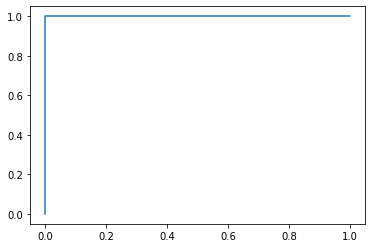

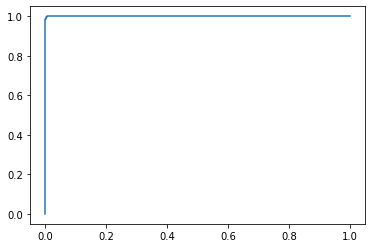

In [29]:
# ROC Train
FPR_train, recall_train, thresholds_train = roc_curve(y_train, xgb_clf.predict_proba(X_train)[:,1], pos_label=1)
#FPR_train, recall_train, thresholds_train = roc_curve(YTrain, result[:,1], pos_label=1)
plt.plot(FPR_train, recall_train)
plt.show()
# ROC Test
FPR_test, recall_test, thresholds_test = roc_curve(y_test, xgb_clf.predict_proba(X_test)[:,1], pos_label=1)
#FPR_test, recall_test, thresholds_test = roc_curve(YTest, result_test[:,1], pos_label=1)
plt.plot(FPR_test, recall_test)
plt.show()

**AUC**

In [30]:
auc_train = roc_auc_score(y_train, xgb_clf.predict(X_train))
auc_test = roc_auc_score(y_test, xgb_clf.predict(X_test))
print("训练集AUC值： ",auc_train)
print("测试集AUC值： ",auc_test)

训练集AUC值：  1.0
测试集AUC值：  0.9959559622727401


**F1**

In [31]:
f1_train = f1_score(y_train,xgb_clf.predict(X_train))
f1_test = f1_score(y_test, xgb_clf.predict(X_test))
print("训练集F1分数： ",f1_train)
print("测试集F1分数： ",f1_test)

训练集F1分数：  1.0
测试集F1分数：  0.9942262186464742


**Confusion Matrix**

In [32]:
confusion_matrix(y_train,xgb_clf.predict(X_train))

array([[27823,     0],
       [    0, 12142]])

In [33]:
confusion_matrix(y_test,xgb_clf.predict(X_test))

array([[11816,    33],
       [   28,  5252]])

**recall**

In [34]:
recall_train = recall_score(y_train,xgb_clf.predict(X_train))
recall_test = recall_score(y_test,xgb_clf.predict(X_test))
print("训练集召回率：",recall_train)
print("测试集召回率：",recall_test)

训练集召回率： 1.0
测试集召回率： 0.9946969696969697


**KS**

In [35]:
fpr,tpr,thresholds= roc_curve(y_test, xgb_clf.predict(X_test), pos_label=1)
print ('KS:',max(tpr-fpr))

KS: 0.9919119245454802


### 使用LIME局部解释查看效果 结果：选取的7个特征在测试集中的平均hit数为1.47

In [36]:
#lime = LimeTabular(predict_fn=xgb_clf.predict_proba, data=X_train)  
#lime_local = lime.explain_local(X_test, y_test)  #解释第0-5样本
#show(lime_local)
from lime.lime_tabular import LimeTabularExplainer
limeexplainer = LimeTabularExplainer(X_train.values,feature_names=X_train.columns,discretize_continuous=True,discretizer="quartile",verbose=True,mode = "classification")
exp = limeexplainer.explain_instance(X_test.iloc[0], xgb_clf.predict_proba, num_features=10)
exp.show_in_notebook(show_table=True, show_all=False)

Intercept 0.4579520503533264
Prediction_local [0.02568855]
Right: 5.843127e-07


In [ ]:
count = 0
for i in range(X_test.shape[0]):
    count += compare(target_list,lime_local._internal_obj["specific"][i]["names"])
    print(lime_local._internal_obj["specific"][i]["names"])
count /= X_test.shape[0]
count

In [ ]:
def extract_from_exp(exp,columns):
    exp_local = exp.local_exp[1]
    result_list = []
    for i in range(len(exp_local)):
        result_list.append(columns[exp_local[i][0]])
    return result_list
from lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(X_train.values, feature_names=X_train.columns)
count = 0
for i in range(X_test.shape[0]):
    exp = explainer.explain_instance(X_test.iloc[i], xgb_clf.predict_proba, num_features=10)
    result_list = extract_from_exp(exp,X_train.columns)
    count += compare(target_list,result_list)
count /= X_test.shape[0]
#show(lime_local)

In [114]:
exp.local_exp[1]

[(39, -0.05999971989457629),
 (5, -0.03257017736444564),
 (90, -0.026731804139571387),
 (62, -0.025556417903239852),
 (81, 0.015063313172601862),
 (30, -0.014263970713046139),
 (87, 0.011582197847462365),
 (31, -0.010723847267593001),
 (78, -0.009946290904418892),
 (27, 0.009171191572112958)]

### 使用SHAP局部解释查看效果 7个特征在测试集中平均hit数为4.88

In [37]:
'''
shap = ShapKernel(predict_fn=xgb_clf.predict_proba, data=X_train.iloc[:8000],n_jobs=15)  # 多进程用多了内存容易爆
shap_local = shap.explain_local(X_test[:5], y_test[:5])
show(shap_local)
''' #interpretml的可视化会消耗大量时间

'\nshap = ShapKernel(predict_fn=xgb_clf.predict_proba, data=X_train.iloc[:8000],n_jobs=15)  # 多进程用多了内存容易爆\nshap_local = shap.explain_local(X_test[:5], y_test[:5])\nshow(shap_local)\n'

In [38]:
import shap
explainer = shap.TreeExplainer(xgb_clf)
#explainer  = shap.Explainer(xgb_clf)
shap_values = explainer.shap_values(X_test)  # 传入特征矩阵X，计算SHAP值

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [39]:
count = 0
for i in range(len(shap_values)):
    shap_val = shap_values[i]
    df_row = pd.DataFrame(np.array(shap_val).reshape(1,-1),columns = X_train.columns)
    df_new = df_row.copy().abs()

    df_new = df_new.sort_values(by =0,axis = 1,ascending = False).iloc[:,:10]
    count += compare(target_list,df_new.columns)
count = count / len(shap_values)
count

4.877634421157102

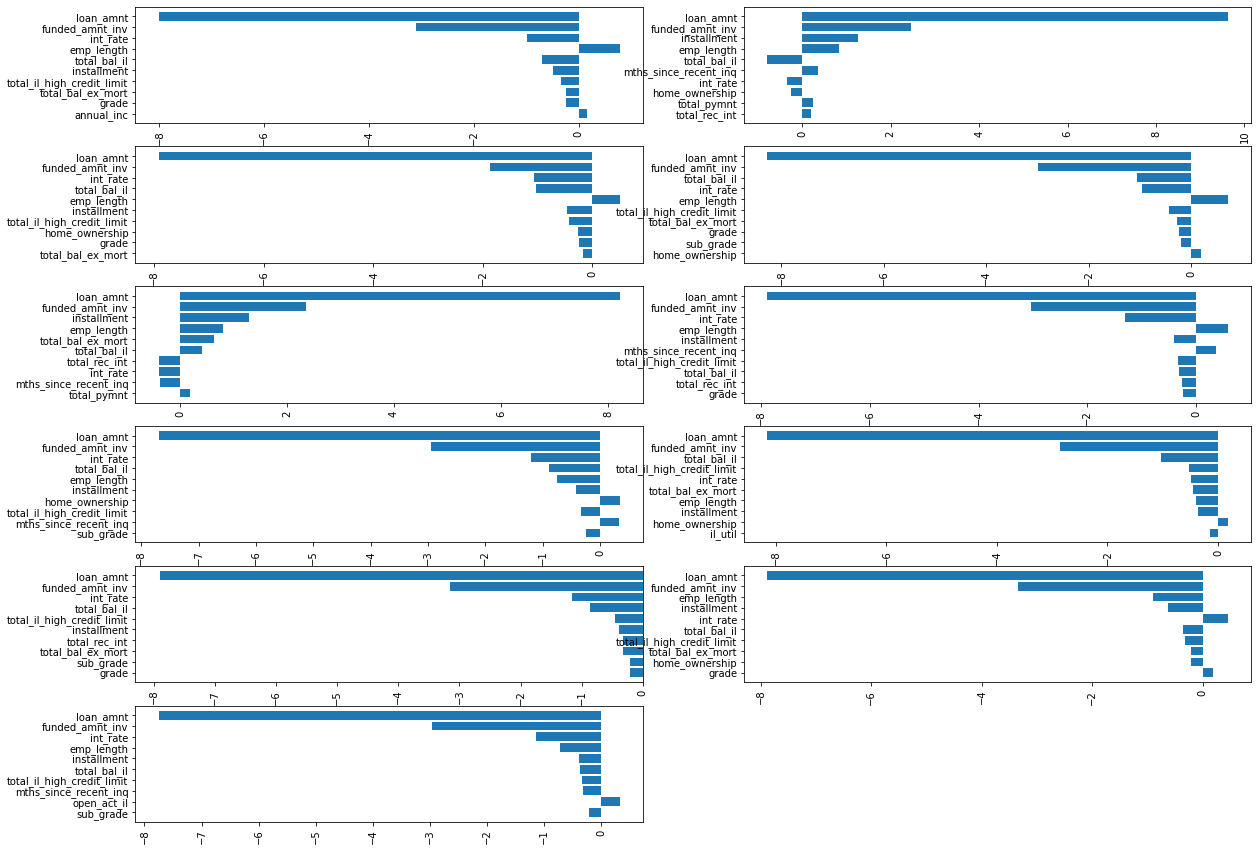

In [40]:
def plot_sorted_value(shap_values,columns,numberth):
    #plt.rcParams['font.sans-serif'] = ['SimHei']
    #plt.rcParams['axes.unicode_minus'] = False
    shap_val = shap_values[numberth,:]
    df_row = pd.DataFrame(np.array(shap_val).reshape(1,-1),columns = columns)
    df_new = df_row.copy().abs()

    df_new = df_new.sort_values(by =0,axis = 1,ascending = False).iloc[:,:10]
    #print(type(df_row[df_new.columns].values[0]))
    plt.barh(np.flipud(df_new.columns),np.flipud(df_row[df_new.columns].values[0]))
    plt.xticks(rotation=90)
fig = plt.figure(figsize =(20,15))
pic_num = 11
for i in range(pic_num):
    ax = fig.add_subplot(int(pic_num/2) if pic_num%2==0 else int(pic_num/2) +1,2,i+1)
    plot_sorted_value(shap_values,X_train.columns,i)

### 使用EBMBoosting解释 7个特征在测试集的平均hit数为2.30但是EBMBoosting解释会产生特征交互

In [41]:
def hit_count(string, target_list): #针对emb存在交互特征的问题
    hit = 0
    for i in target_list:
        index = string.find(i)
        if index != -1:
            hit += 1
    return hit

In [42]:
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)
ebm_local = ebm.explain_local(X_test, y_test)
count = 0
for i in range(X_test.shape[0]):
    tmp = pd.DataFrame(np.array(ebm_local._internal_obj["specific"][i]["scores"]).reshape(1,-1),columns = ebm_local._internal_obj["specific"][i]["names"])
    tmp_abs = tmp.copy().abs()
    tmp_result = tmp[tmp_abs.sort_values(by = 0, axis = 1,ascending = False).iloc[:,:10].columns]
    string_combine = ""
    for j in tmp_result.columns:
        string_combine += j
    count += hit_count(string_combine,target_list)
count = count/X_test.shape[0]
count

2.302644637748847

In [43]:
'''
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)
ebm_local = ebm.explain_local(X_test.iloc[:5], y_test.iloc[:5])
show(ebm_local)
'''

'\nebm = ExplainableBoostingClassifier()\nebm.fit(X_train, y_train)\nebm_local = ebm.explain_local(X_test.iloc[:5], y_test.iloc[:5])\nshow(ebm_local)\n'

### 线性生成Label结果图

$y = normalize(0.1 \times x["loan \_ amnt"] + 10\times x["int \_ rate"] + 5\times x["emp \_length"])+ 2 \times    x["open\_acc"]+10\times x["home\_ownership"]+ 0.001 \times x["total\_bc\_limit"] - 2 \times x["mths\_since\_recent\_inq"])$

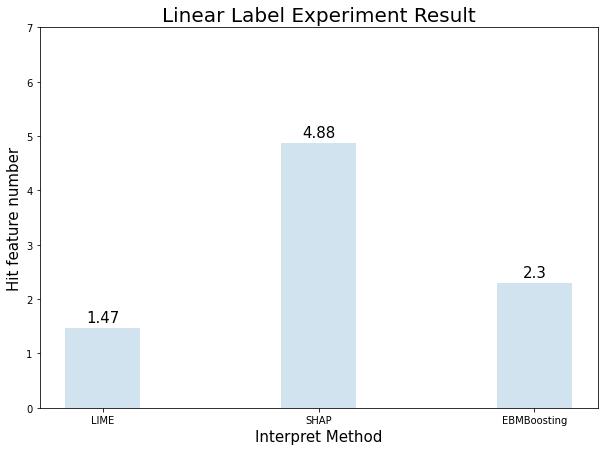

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
name_list = ['LIME','SHAP','EBMBoosting']
num_list = [1.47,4.88,2.30]
for a, b in zip(name_list, num_list):
    ax.text(a, b+0.05, b, ha='center', va='bottom',size = 15)
b = ax.bar(name_list, num_list,width = 0.35,alpha = 0.2)
#ax.text(1, 3.5, r"$y = normalize(0.01 \times x[\"loan \_ amnt\"] + 10\times x[\"int \_ rate\"] + 5\times x[\"emp \_length\"])$",fontsize=20)
#plt.bar(range(len(num_list)), num_list,color='rbg',tick_label=name_list)
plt.title('Linear Label Experiment Result',size = 20)
plt.xlabel('Interpret Method',size = 15)
plt.ylabel('Hit feature number',size = 15)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.ylim(0,7)
plt.rcParams['figure.figsize'] = (10,7)

## 使用一定的非线性生成label

In [44]:
df_norm

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,target
0,15000.0,15000.0,15000.0,60.0,5.32,451.73,0.0,0.0,10.0,0.0,105000.0,1.0,1.0,26,14.24,0.0,775.0,779.0,0.0,34.224381,10.0,0.0,13367.0,38.9,20.0,0.0,0.00,0.00,15838.304347,15838.30,15000.00,838.30,0.0,0.0,0.0,719.0,715.0,0.0,0.0,0.0,0.0,60303.0,1.0,4.0,3.0,3.0,5.0,37177.0,87.0,0.0,1.0,7277.0,66.0,34400.0,0.0,0.0,0.0,4.0,6030.0,15033.0,47.1,0.0,0.0,142.0,210.0,22.0,5.0,2.0,22.0,6.522204,0.0,3.0,3.0,3.0,4.0,11.0,5.0,7.0,3.0,10.0,0.0,0.0,0.0,3.0,100.0,0.0,0.0,0.0,155369.0,50544.0,28400.0,42806.0,0.0,0.0,0
1,4800.0,4800.0,4800.0,60.0,7.99,150.40,0.0,4.0,10.0,2.0,110000.0,2.0,2.0,6,16.29,0.0,790.0,794.0,2.0,34.224381,11.0,0.0,46669.0,42.4,30.0,0.0,1729.75,1729.75,3607.470000,3607.47,3070.25,537.22,0.0,0.0,0.0,649.0,645.0,0.0,0.0,0.0,0.0,316154.0,0.0,3.0,0.0,2.0,17.0,21736.0,53.0,2.0,6.0,6676.0,45.0,119000.0,4.0,0.0,4.0,8.0,28741.0,72306.0,16.7,0.0,0.0,63.0,290.0,7.0,7.0,3.0,7.0,5.000000,0.0,4.0,5.0,6.0,16.0,5.0,7.0,22.0,5.0,11.0,0.0,0.0,0.0,2.0,100.0,0.0,0.0,0.0,509315.0,68405.0,85000.0,40715.0,0.0,0.0,0
2,15000.0,15000.0,15000.0,60.0,10.49,487.47,1.0,11.0,10.0,0.0,75000.0,0.0,0.0,35,10.38,0.0,705.0,709.0,0.0,36.000000,9.0,0.0,4289.0,39.0,57.0,1.0,0.00,0.00,17204.184465,17204.18,15000.00,2204.18,0.0,0.0,0.0,694.0,690.0,0.0,0.0,0.0,316.0,83201.0,2.0,3.0,2.0,5.0,2.0,13139.0,76.0,1.0,3.0,2804.0,61.0,11000.0,0.0,1.0,3.0,8.0,10400.0,3496.0,44.5,0.0,0.0,266.0,113.0,4.0,2.0,1.0,4.0,11.000000,1.0,1.0,3.0,1.0,5.0,47.0,5.0,9.0,3.0,9.0,0.0,0.0,0.0,3.0,94.7,0.0,0.0,0.0,100922.0,17428.0,6300.0,17371.0,0.0,0.0,0
3,3000.0,3000.0,3000.0,60.0,5.32,90.35,0.0,0.0,9.0,0.0,78000.0,2.0,2.0,42,22.11,0.0,770.0,774.0,0.0,57.000000,14.0,0.0,12410.0,20.2,24.0,0.0,0.00,0.00,3035.931710,3035.93,3000.00,35.93,0.0,0.0,0.0,754.0,750.0,0.0,0.0,0.0,0.0,122270.0,1.0,2.0,0.0,1.0,17.0,11256.0,43.0,1.0,2.0,10269.0,24.0,61300.0,0.0,0.0,3.0,3.0,8734.0,48890.0,20.2,0.0,0.0,108.0,155.0,2.0,2.0,4.0,2.0,10.000000,0.0,2.0,2.0,10.0,13.0,4.0,10.0,16.0,2.0,14.0,0.0,0.0,0.0,1.0,95.8,0.0,0.0,0.0,254797.0,23666.0,61300.0,56497.0,0.0,0.0,0
4,8000.0,8000.0,8000.0,60.0,13.49,271.45,2.0,21.0,4.0,0.0,55000.0,2.0,3.0,24,9.56,1.0,720.0,724.0,1.0,14.000000,14.0,0.0,20549.0,31.0,25.0,0.0,0.00,0.00,8421.381904,8421.38,8000.00,421.38,0.0,0.0,0.0,694.0,690.0,0.0,0.0,0.0,0.0,113222.0,0.0,2.0,0.0,1.0,22.0,4812.0,65.0,0.0,4.0,10882.0,34.0,66300.0,2.0,0.0,4.0,6.0,8087.0,31851.0,39.2,0.0,0.0,81.0,120.0,13.0,10.0,1.0,13.0,0.000000,0.0,4.0,4.0,7.0,11.0,7.0,11.0,17.0,4.0,14.0,0.0,0.0,0.0,1.0,96.0,14.3,0.0,0.0,163222.0,25361.0,52400.0,7462.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

$y = normalize( \sqrt{x["loan \_ amnt"]} + \frac{1}{x["int \_ rate"]+\epsilon} 10 \times x["emp \_length"]^2)+tanh(x["open\_acc"]+20 \times sigmoid(x["home\_ownership"])+10 \times sigmoid(x["total\_bal\_il"])$

In [45]:
target_list = ["loan_amnt","int_rate","emp_length","open_acc","home_ownership","total_bal_il"]
df_norm["target"] = np.sqrt(df_norm["loan_amnt"]) + 1 /(df_norm["int_rate"]+0.00001)+ 10*df_norm["emp_length"]*df_norm["emp_length"]+tanh(df_norm["open_acc"])+20*sigmoid(df_norm["home_ownership"])+10*sigmoid(df_norm["total_bal_il"])
df_norm["target"] = (normalize(df_norm["target"])>0.4).astype(int)
df_norm["target"].value_counts()

0    30813
1    26281
Name: target, dtype: int64

In [46]:
X,y = df_norm.iloc[:,:-1],df_norm.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
xgb_clf = xgboost.XGBClassifier()
#xgb_lcf = xgboost.XGBRegressor()
xgb_clf.fit(X_train,y_train)


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:16:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=32, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

**Accuracy**

In [47]:
xgb_clf.score(X_test,y_test)

0.9998248584272287

**ROC**

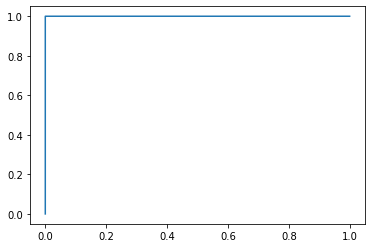

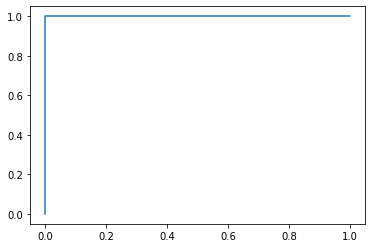

In [48]:
# ROC Train
FPR_train, recall_train, thresholds_train = roc_curve(y_train, xgb_clf.predict_proba(X_train)[:,1], pos_label=1)
#FPR_train, recall_train, thresholds_train = roc_curve(YTrain, result[:,1], pos_label=1)
plt.plot(FPR_train, recall_train)
plt.show()
# ROC Test
FPR_test, recall_test, thresholds_test = roc_curve(y_test, xgb_clf.predict_proba(X_test)[:,1], pos_label=1)
#FPR_test, recall_test, thresholds_test = roc_curve(YTest, result_test[:,1], pos_label=1)
plt.plot(FPR_test, recall_test)
plt.show()

**AUC**

In [49]:
auc_train = roc_auc_score(y_train, xgb_clf.predict(X_train))
auc_test = roc_auc_score(y_test, xgb_clf.predict(X_test))
print("训练集AUC值： ",auc_train)
print("测试集AUC值： ",auc_test)

训练集AUC值：  1.0
测试集AUC值：  0.9998375216637782


**F1**

In [50]:
f1_train = f1_score(y_train,xgb_clf.predict(X_train))
f1_test = f1_score(y_test, xgb_clf.predict(X_test))
print("训练集F1分数： ",f1_train)
print("测试集F1分数： ",f1_test)

训练集F1分数：  1.0
测试集F1分数：  0.9998100905235171


**Confusion Matrix**

In [51]:
confusion_matrix(y_train,xgb_clf.predict(X_train))

array([[21581,     0],
       [    0, 18384]])

In [52]:
confusion_matrix(y_test,xgb_clf.predict(X_test))

array([[9229,    3],
       [   0, 7897]])

**recall**

In [53]:
recall_train = recall_score(y_train,xgb_clf.predict(X_train))
recall_test = recall_score(y_test,xgb_clf.predict(X_test))
print("训练集召回率：",recall_train)
print("测试集召回率：",recall_test)

训练集召回率： 1.0
测试集召回率： 1.0


**KS**

In [54]:
fpr,tpr,thresholds= roc_curve(y_test, xgb_clf.predict(X_test), pos_label=1)
print ('KS:',max(tpr-fpr))

KS: 0.9996750433275563


### 使用LIME解释  7个特征在测试集中的平局hit数为1.18

In [77]:
lime = LimeTabular(predict_fn=xgb_clf.predict_proba, data=X_train)
lime_local = lime.explain_local(X_test.iloc[:5], y_test.iloc[:5])

#show(lime_local)

### 使用SHAP解释 7个特征在测试集中的平局hit数为3.85

In [56]:
import shap
explainer = shap.TreeExplainer(xgb_clf)
#explainer  = shap.Explainer(xgb_clf)
shap_values = explainer.shap_values(X_test)  # 传入特征矩阵X，计算SHAP值

/root/anaconda3/envs/interpret/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



In [57]:
count = 0
for i in range(len(shap_values)):
    shap_val = shap_values[i]
    df_row = pd.DataFrame(np.array(shap_val).reshape(1,-1),columns = X_train.columns)
    df_new = df_row.copy().abs()

    df_new = df_new.sort_values(by =0,axis = 1,ascending = False).iloc[:,:10]
    count += compare(target_list,df_new.columns)
count = count / len(shap_values)
count

3.8464592212038062

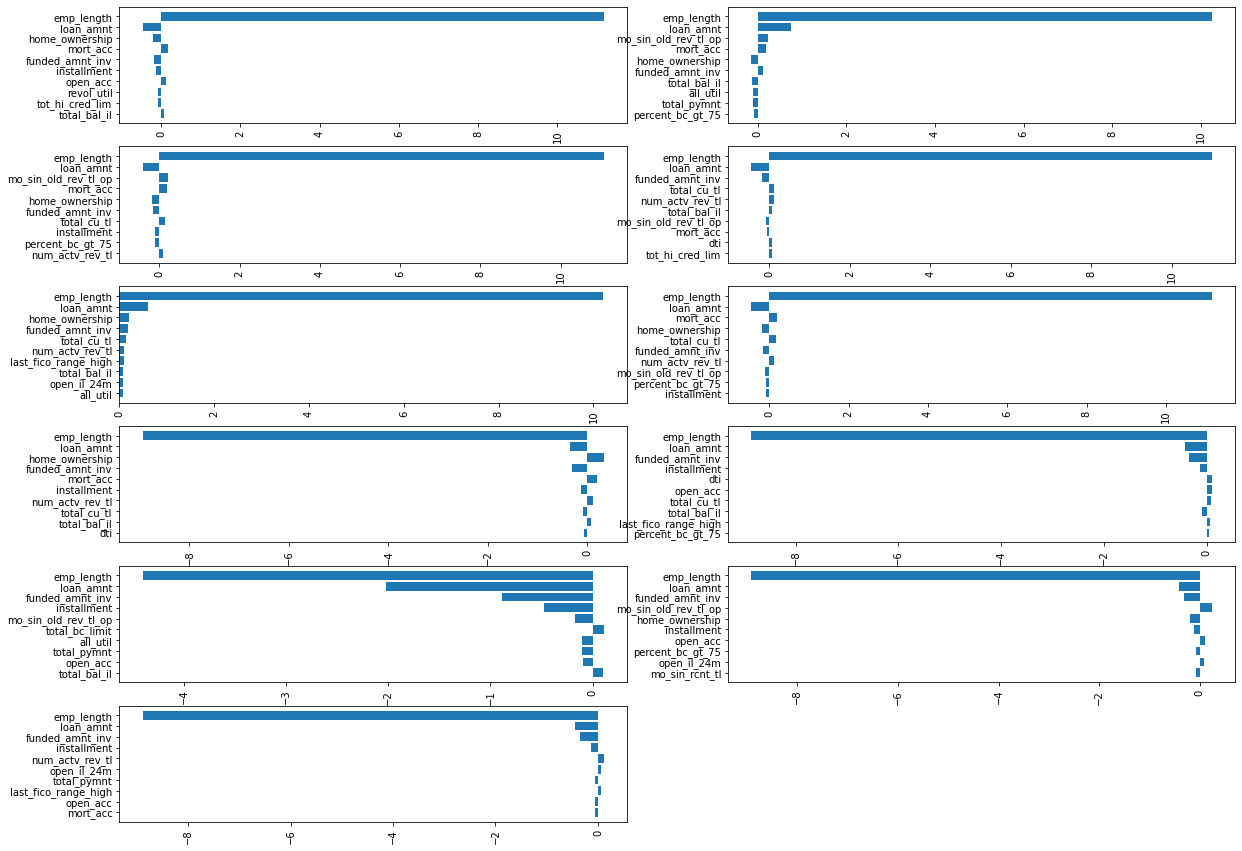

In [58]:
def plot_sorted_value(shap_values,columns,numberth):
    #plt.rcParams['font.sans-serif'] = ['SimHei']
    #plt.rcParams['axes.unicode_minus'] = False
    shap_val = shap_values[numberth,:]
    df_row = pd.DataFrame(np.array(shap_val).reshape(1,-1),columns = columns)
    df_new = df_row.copy().abs()

    df_new = df_new.sort_values(by =0,axis = 1,ascending = False).iloc[:,:10]
    #print(type(df_row[df_new.columns].values[0]))
    plt.barh(np.flipud(df_new.columns),np.flipud(df_row[df_new.columns].values[0]))
    plt.xticks(rotation=90)
fig = plt.figure(figsize =(20,15))
pic_num = 11
for i in range(pic_num):
    ax = fig.add_subplot(int(pic_num/2) if pic_num%2==0 else int(pic_num/2) +1,2,i+1)
    plot_sorted_value(shap_values,X_train.columns,i)

### EBMBoosting 7个特征在随机选取的测试集中的平局hit数为2.01

In [59]:
def hit_count(string, target_list): #针对emb存在交互特征的问题
    hit = 0
    for i in target_list:
        index = string.find(i)
        if index != -1:
            hit += 1
    return hit
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)
ebm_local = ebm.explain_local(X_test, y_test)
count = 0
for i in range(X_test.shape[0]):
    tmp = pd.DataFrame(np.array(ebm_local._internal_obj["specific"][i]["scores"]).reshape(1,-1),columns = ebm_local._internal_obj["specific"][i]["names"])
    tmp_abs = tmp.copy().abs()
    tmp_result = tmp[tmp_abs.sort_values(by = 0, axis = 1,ascending = False).iloc[:,:10].columns]
    string_combine = ""
    for j in tmp_result.columns:
        string_combine += j
    count += hit_count(string_combine,target_list)
count = count/X_test.shape[0]
count

2.0146535115885342

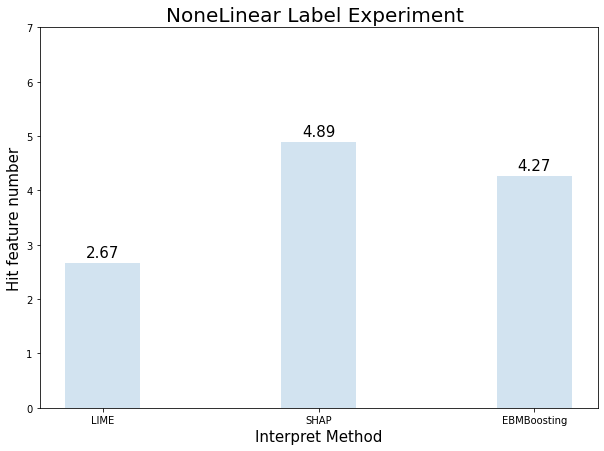

In [9]:
fig, ax = plt.subplots()
name_list = ['LIME','SHAP','EBMBoosting']
num_list = [2.67,4.89,4.27]
for a, b in zip(name_list, num_list):
    ax.text(a, b+0.05, b, ha='center', va='bottom',size = 15)
b = ax.bar(name_list, num_list,width = 0.35,alpha = 0.2)
#ax.text(1, 3.5, r"$y = normalize(0.01 \times x[\"loan \_ amnt\"] + 10\times x[\"int \_ rate\"] + 5\times x[\"emp \_length\"])$",fontsize=20)
#plt.bar(range(len(num_list)), num_list,color='rbg',tick_label=name_list)
plt.title('NoneLinear Label Experiment ',size = 20)
plt.xlabel('Interpret Method',size = 15)
plt.ylabel('Hit feature number',size = 15)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.ylim(0,7)
plt.rcParams['figure.figsize'] = (10,7)

## 交互特征

$y = normalize(log(x["loan\_amnt"]+0.5 \times x["annual\_inc"])+0.0008 \times x["loan\_amnt"] \times x["int\_rate"] + \sqrt{x["total\_rec\_int"]+x["tot\_coll\_amt"]}$

In [62]:
df_norm["total_rec_int"]

0         838.30
1         537.22
2        2204.18
3          35.93
4         421.38
          ...   
57089    1274.13
57090    6018.87
57091    2756.23
57092    6448.76
57093    1861.47
Name: total_rec_int, Length: 57094, dtype: float64

In [63]:
import math
target_list = ["loan_amnt","annual_inc","int_rate","total_rec_int","tot_coll_amt"]
df_norm["target"] = (df_norm["loan_amnt"]+0.5*df_norm["annual_inc"]).apply(np.log1p)+0.0008*df_norm["loan_amnt"]*df_norm["int_rate"]+np.sqrt(df_norm["total_rec_int"]+df_norm["tot_coll_amt"])
df_norm["target"] = (normalize(df_norm["target"])>0.4).astype(int)
df_norm["target"].value_counts()

0    51258
1     5836
Name: target, dtype: int64

In [64]:
X,y = df_norm.iloc[:,:-1],df_norm.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
xgb_clf = xgboost.XGBClassifier()
#xgb_lcf = xgboost.XGBRegressor()
xgb_clf.fit(X_train,y_train)


/root/anaconda3/envs/interpret/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[15:19:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=32, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

**Accuracy**

In [65]:
xgb_clf.score(X_test,y_test)

0.9970225932628874

**ROC**

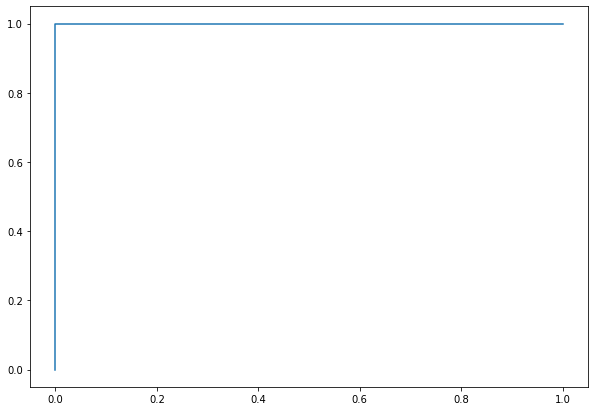

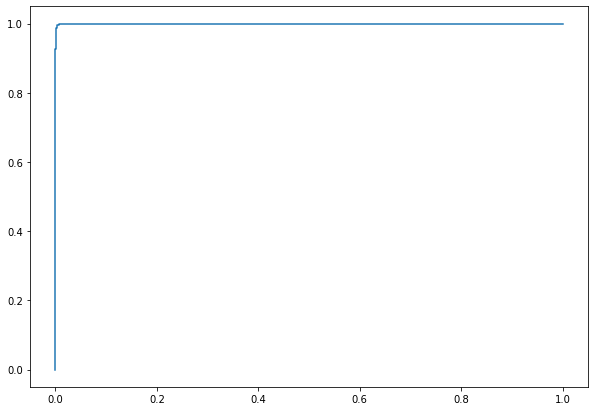

In [66]:
# ROC Train
FPR_train, recall_train, thresholds_train = roc_curve(y_train, xgb_clf.predict_proba(X_train)[:,1], pos_label=1)
#FPR_train, recall_train, thresholds_train = roc_curve(YTrain, result[:,1], pos_label=1)
plt.plot(FPR_train, recall_train)
plt.show()
# ROC Test
FPR_test, recall_test, thresholds_test = roc_curve(y_test, xgb_clf.predict_proba(X_test)[:,1], pos_label=1)
#FPR_test, recall_test, thresholds_test = roc_curve(YTest, result_test[:,1], pos_label=1)
plt.plot(FPR_test, recall_test)
plt.show()

**AUC**

In [67]:
auc_train = roc_auc_score(y_train, xgb_clf.predict(X_train))
auc_test = roc_auc_score(y_test, xgb_clf.predict(X_test))
print("训练集AUC值： ",auc_train)
print("测试集AUC值： ",auc_test)

训练集AUC值：  1.0
测试集AUC值：  0.9906551507098296


**F1**

In [68]:
f1_train = f1_score(y_train,xgb_clf.predict(X_train))
f1_test = f1_score(y_test, xgb_clf.predict(X_test))
print("训练集F1分数： ",f1_train)
print("测试集F1分数： ",f1_test)

训练集F1分数：  1.0
测试集F1分数：  0.9856540084388186


**Confusion Matrix**

In [69]:
confusion_matrix(y_train,xgb_clf.predict(X_train))

array([[35912,     0],
       [    0,  4053]])

In [70]:
confusion_matrix(y_test,xgb_clf.predict(X_test))

array([[15326,    20],
       [   31,  1752]])

**recall**

In [71]:
recall_train = recall_score(y_train,xgb_clf.predict(X_train))
recall_test = recall_score(y_test,xgb_clf.predict(X_test))
print("训练集召回率：",recall_train)
print("测试集召回率：",recall_test)

训练集召回率： 1.0
测试集召回率： 0.9826135726303982


**KS**

In [72]:
fpr,tpr,thresholds= roc_curve(y_test, xgb_clf.predict(X_test), pos_label=1)
print ('KS:',max(tpr-fpr))

KS: 0.9813103014196592


### 使用LIME解释 5个特征在测试集中的平均hit数为3.41

### 使用SHAP解释 5个特征在测试集中的平局hit数为3.99

In [73]:
import shap
explainer = shap.TreeExplainer(xgb_clf)
#explainer  = shap.Explainer(xgb_clf)
shap_values = explainer.shap_values(X_test)  # 传入特征矩阵X，计算SHAP值
count = 0
for i in range(len(shap_values)):
    shap_val = shap_values[i]
    df_row = pd.DataFrame(np.array(shap_val).reshape(1,-1),columns = X_train.columns)
    df_new = df_row.copy().abs()

    df_new = df_new.sort_values(by =0,axis = 1,ascending = False).iloc[:,:10]
    count += compare(target_list,df_new.columns)
count = count / len(shap_values)
count

/root/anaconda3/envs/interpret/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



3.988966080915407

### EBMBoosting 7个特征在随机选取的测试集中的平局hit数为2.66

In [74]:
def hit_count(string, target_list): #针对emb存在交互特征的问题
    hit = 0
    for i in target_list:
        index = string.find(i)
        if index != -1:
            hit += 1
    return hit
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)
ebm_local = ebm.explain_local(X_test, y_test)
count = 0
for i in range(X_test.shape[0]):
    tmp = pd.DataFrame(np.array(ebm_local._internal_obj["specific"][i]["scores"]).reshape(1,-1),columns = ebm_local._internal_obj["specific"][i]["names"])
    tmp_abs = tmp.copy().abs()
    tmp_result = tmp[tmp_abs.sort_values(by = 0, axis = 1,ascending = False).iloc[:,:10].columns]
    string_combine = ""
    for j in tmp_result.columns:
        string_combine += j
    count += hit_count(string_combine,target_list)
count = count/X_test.shape[0]
count

2.6614513398330315

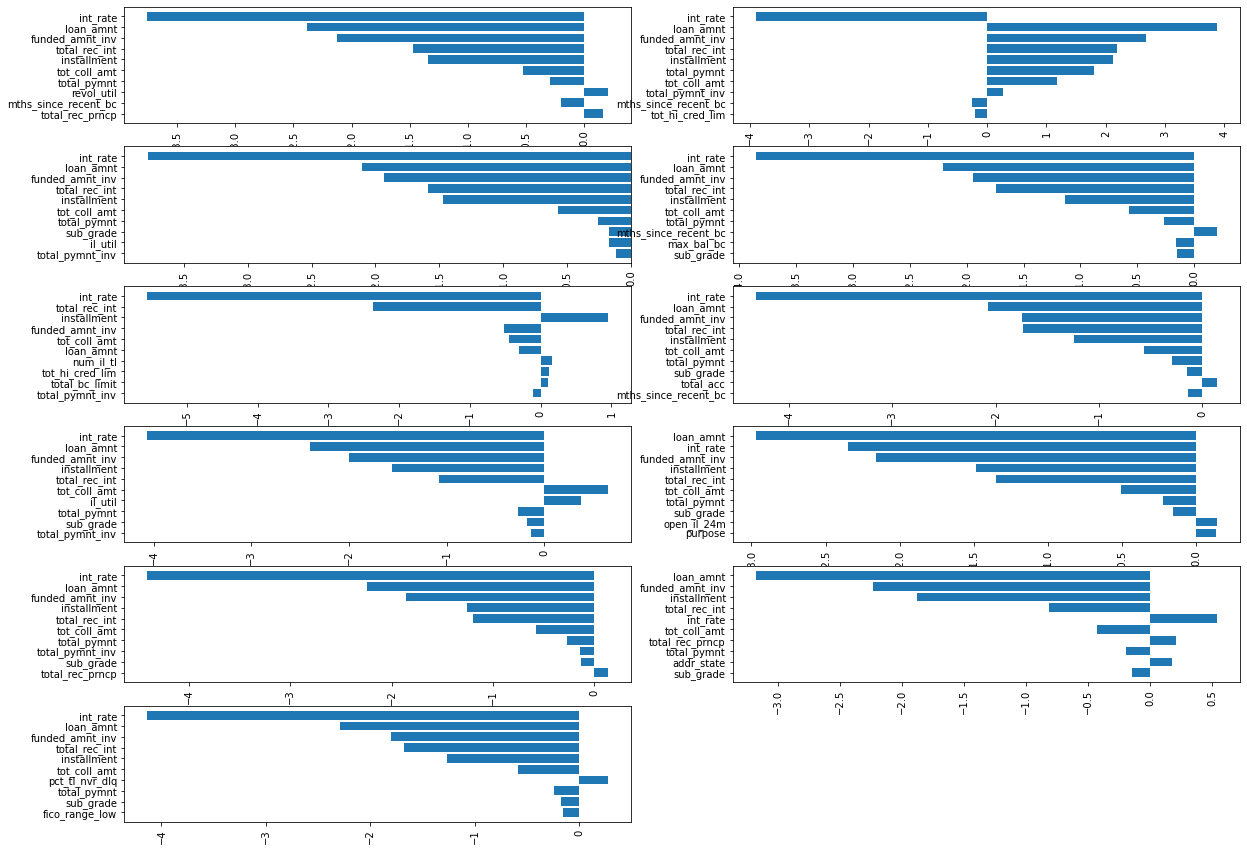

In [75]:
def plot_sorted_value(shap_values,columns,numberth):
    #plt.rcParams['font.sans-serif'] = ['SimHei']
    #plt.rcParams['axes.unicode_minus'] = False
    shap_val = shap_values[numberth,:]
    df_row = pd.DataFrame(np.array(shap_val).reshape(1,-1),columns = columns)
    df_new = df_row.copy().abs()

    df_new = df_new.sort_values(by =0,axis = 1,ascending = False).iloc[:,:10]
    #print(type(df_row[df_new.columns].values[0]))
    plt.barh(np.flipud(df_new.columns),np.flipud(df_row[df_new.columns].values[0]))
    plt.xticks(rotation=90)
fig = plt.figure(figsize =(20,15))
pic_num = 11
for i in range(pic_num):
    ax = fig.add_subplot(int(pic_num/2) if pic_num%2==0 else int(pic_num/2) +1,2,i+1)
    plot_sorted_value(shap_values,X_train.columns,i)

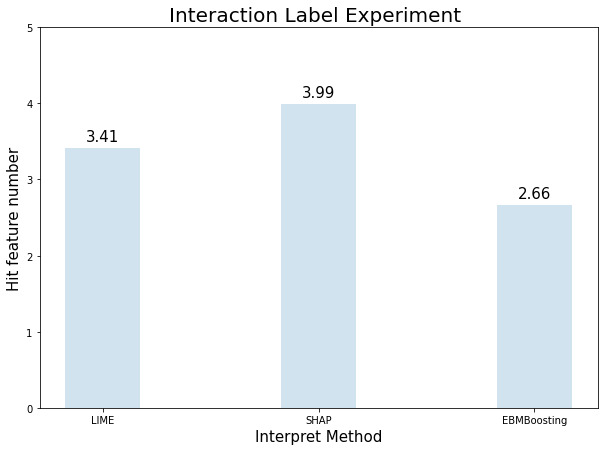

In [11]:
fig, ax = plt.subplots()
name_list = ['LIME','SHAP','EBMBoosting']
num_list = [3.41,3.99,2.66]
for a, b in zip(name_list, num_list):
    ax.text(a, b+0.05, b, ha='center', va='bottom',size = 15)
b = ax.bar(name_list, num_list,width = 0.35,alpha = 0.2)
#ax.text(1, 3.5, r"$y = normalize(0.01 \times x[\"loan \_ amnt\"] + 10\times x[\"int \_ rate\"] + 5\times x[\"emp \_length\"])$",fontsize=20)
#plt.bar(range(len(num_list)), num_list,color='rbg',tick_label=name_list)
plt.title('Interaction Label Experiment ',size = 20)
plt.xlabel('Interpret Method',size = 15)
plt.ylabel('Hit feature number',size = 15)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.ylim(0,5)
plt.rcParams['figure.figsize'] = (10,7)

**初步分析**
- 添加构成target特征数量后，各方法hit比例均有一定下降
- 选用SHAP.TreeExplainer替代SHAP.kernelExplainer，时间复杂度大幅下降,因此将实验验证数据集设定为测试集(17129,94)
- 现在的主要局限是LIME的解释时间复杂度，解释一个样本约需要30秒，解释整个测试集需要142小时
- 使用多线程LIME，16线程，约需要17小时
- 特征增加后LIME的解释效果相比另外两项差距较大
- 分析数据后发现数据集中部分列存在强相关性，因此推断经过特征筛选后再进行可解释实验可以得到更好的解释效果
- 目前结果是SHAP>EBMBoosting>LIME
- 解释效果 Linear>Nonlinear>Interaction